# Process true trajectories

Aggregate, process, plot some and save all true trajectories' features. 

---

# Imports

In [1]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
plt.style.use("ggplot")
sns.set_context("paper")

# Explore individual files (for one single video)

In [3]:
data_path = Path("analyses", "biotine_nuclei_tracked")

In [4]:
plate = "A_13_fld_4"

cell_nucleus = pd.read_csv(data_path / plate / "cell_nucleus.csv")
filtered_nucleus = pd.read_csv(data_path / plate / "filtered_nucleus.csv")
image = pd.read_csv(data_path / plate / "Image.csv")
whole_cell = pd.read_csv(data_path / plate / "whole_cell.csv")

print("cell_nucleus:", cell_nucleus.columns)
print("filtered_nucleus:", filtered_nucleus.columns)
print("image:", image.columns)
print("whole_cell:", whole_cell.columns)

cell_nucleus: Index(['ImageNumber', 'ObjectNumber', 'Metadata_FileLocation',
       'Metadata_Frame', 'Metadata_Series', 'Metadata_VideoID',
       'Metadata_VideoID.1', 'Metadata_Well', 'Metadata_column',
       'Metadata_field', 'Metadata_row', 'Metadata_time', 'FileName_images',
       'PathName_images', 'Children_filtered_nucleus_Count',
       'Children_whole_cell_Count', 'Location_Center_X', 'Location_Center_Y',
       'Location_Center_Z', 'Number_Object_Number'],
      dtype='object')
filtered_nucleus: Index(['ImageNumber', 'ObjectNumber', 'Metadata_FileLocation',
       'Metadata_Frame', 'Metadata_Series', 'Metadata_VideoID',
       'Metadata_VideoID.1', 'Metadata_Well', 'Metadata_column',
       'Metadata_field',
       ...
       'TrackObjects_DistanceTraveled_10', 'TrackObjects_FinalAge_10',
       'TrackObjects_IntegratedDistance_10', 'TrackObjects_Label_10',
       'TrackObjects_Lifetime_10', 'TrackObjects_Linearity_10',
       'TrackObjects_ParentImageNumber_10',
       '

In [5]:
print(
    "common columns:",
    set(cell_nucleus.columns)
    & set(filtered_nucleus.columns)
    & set(image.columns)
    & set(whole_cell.columns),
)

common columns: {'Metadata_row', 'ImageNumber', 'PathName_images', 'Metadata_Well', 'Metadata_Frame', 'Metadata_Series', 'Metadata_FileLocation', 'FileName_images', 'Metadata_field', 'Metadata_column', 'Metadata_VideoID', 'Metadata_time'}


In [8]:
image

,Channel_images,Count_cell_nucleus,Count_filtered_nucleus,Count_whole_cell,ExecutionTime_01Images,ExecutionTime_02Metadata,ExecutionTime_03NamesAndTypes,ExecutionTime_04Groups,ExecutionTime_05ColorToGray,ExecutionTime_06IdentifyPrimaryObjects,...,Threshold_SumOfEntropies_cell_nucleus,Threshold_SumOfEntropies_whole_cell,Threshold_WeightedVariance_cell_nucleus,Threshold_WeightedVariance_whole_cell,TrackObjects_LostObjectCount_filtered_nucleus_10,TrackObjects_MergedObjectCount_filtered_nucleus_10,TrackObjects_NewObjectCount_filtered_nucleus_10,TrackObjects_SplitObjectCount_filtered_nucleus_10,URL_images,Width_images
0,-2,491.0,478.0,478.0,0.0,0.0,4.04,0.00,1.84,9.92,...,-12.686028,-12.478701,0.079435,0.018316,0,0,478,0,file:/projects/static2dynamic/datasets/biotine...,2040
1,-2,488.0,472.0,472.0,0.0,0.0,1.31,0.00,0.14,6.26,...,-12.633328,-12.606086,0.080766,0.020277,10,22,7,16,file:/projects/static2dynamic/datasets/biotine...,2040
2,-2,492.0,474.0,474.0,0.0,0.0,0.92,0.00,0.09,5.84,...,-12.603080,-12.659452,0.082141,0.023902,3,18,9,21,file:/projects/static2dynamic/datasets/biotine...,2040
3,-2,490.0,475.0,475.0,0.0,0.0,0.89,0.00,0.13,5.70,...,-12.566576,-12.771649,0.081421,0.030023,3,12,7,20,file:/projects/static2dynamic/datasets/biotine...,2040
4,-2,484.0,472.0,472.0,0.0,0.0,0.80,0.00,0.12,6.07,...,-12.503967,-12.733705,0.079881,0.037229,6,11,6,20,file:/projects/static2dynamic/datasets/biotine...,2040
5,-2,503.0,493.0,493.0,0.0,0.0,1.12,0.00,0.23,6.20,...,-12.557305,-12.426089,0.078901,0.038750,3,5,7,40,file:/projects/static2dynamic/datasets/biotine...,2040
6,-2,498.0,489.0,489.0,0.0,0.0,0.70,0.00,0.11,6.85,...,-12.485150,-12.343234,0.078321,0.037594,5,15,4,38,file:/projects/static2dynamic/datasets/biotine...,2040
7,-2,499.0,493.0,493.0,0.0,0.0,0.69,0.00,0.09,5.71,...,-12.476724,-12.393352,0.077540,0.037252,5,8,6,42,file:/projects/static2dynamic/datasets/biotine...,2040
8,-2,499.0,494.0,494.0,0.0,0.0,0.65,0.00,0.10,5.98,...,-12.468126,-12.609682,0.076841,0.037911,2,9,2,43,file:/projects/static2dynamic/datasets/biotine...,2040
9,-2,495.0,487.0,487.0,0.0,0.0,1.70,0.00,0.14,6.02,...,-12.422464,-12.587321,0.076248,0.038894,4,17,3,42,file:/projects/static2dynamic/datasets/biotine...,2040


In [6]:
cell_nucleus

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,Metadata_row,Metadata_time,FileName_images,PathName_images,Children_filtered_nucleus_Count,Children_whole_cell_Count,Location_Center_X,Location_Center_Y,Location_Center_Z,Number_Object_Number
0,51,1,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,1,A_13_fld_4_time_01.png,/projects/static2dynamic/datasets/biotine/3_ch...,1,1,1368.620066,19.159539,0,1
1,51,2,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,1,A_13_fld_4_time_01.png,/projects/static2dynamic/datasets/biotine/3_ch...,0,0,540.710072,24.880576,0,2
2,51,3,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,1,A_13_fld_4_time_01.png,/projects/static2dynamic/datasets/biotine/3_ch...,1,1,478.515594,41.115461,0,3
3,51,4,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,1,A_13_fld_4_time_01.png,/projects/static2dynamic/datasets/biotine/3_ch...,1,1,406.350980,37.031373,0,4
4,51,5,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,1,A_13_fld_4_time_01.png,/projects/static2dynamic/datasets/biotine/3_ch...,1,1,168.795300,45.885591,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9364,69,486,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,19,A_13_fld_4_time_19.png,/projects/static2dynamic/datasets/biotine/3_ch...,1,1,1847.906667,2002.897436,0,486
9365,69,487,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,19,A_13_fld_4_time_19.png,/projects/static2dynamic/datasets/biotine/3_ch...,0,0,1465.721921,2000.669249,0,487
9366,69,488,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,19,A_13_fld_4_time_19.png,/projects/static2dynamic/datasets/biotine/3_ch...,1,1,880.962926,2012.390782,0,488
9367,69,489,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,19,A_13_fld_4_time_19.png,/projects/static2dynamic/datasets/biotine/3_ch...,0,0,1507.891740,2003.955092,0,489


In [7]:
filtered_nucleus

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,...,TrackObjects_DistanceTraveled_10,TrackObjects_FinalAge_10,TrackObjects_IntegratedDistance_10,TrackObjects_Label_10,TrackObjects_Lifetime_10,TrackObjects_Linearity_10,TrackObjects_ParentImageNumber_10,TrackObjects_ParentObjectNumber_10,TrackObjects_TrajectoryX_10,TrackObjects_TrajectoryY_10
0,51,1,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.000000,1.0,0.000000,1,1,NaN,0.0,0,0.000000,0.000000
1,51,2,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.000000,NaN,0.000000,2,1,NaN,0.0,0,0.000000,0.000000
2,51,3,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.000000,NaN,0.000000,3,1,NaN,0.0,0,0.000000,0.000000
3,51,4,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.000000,NaN,0.000000,4,1,NaN,0.0,0,0.000000,0.000000
4,51,5,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.000000,NaN,0.000000,5,1,NaN,0.0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9157,69,474,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,1.306136,16.0,62.211930,498,16,0.596324,68.0,480,-0.832771,1.006223
9158,69,475,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,2.113140,17.0,76.192116,494,17,0.495321,68.0,483,1.688521,-1.270535
9159,69,476,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,1.593426,9.0,11.388502,535,9,0.847461,68.0,485,-0.411211,-1.539452
9160,69,477,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.416903,8.0,11.966064,538,8,0.927264,68.0,487,-0.073660,-0.410344


In [9]:
whole_cell

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,...,AreaShape_Zernike_9_3,AreaShape_Zernike_9_5,AreaShape_Zernike_9_7,AreaShape_Zernike_9_9,Location_Center_X,Location_Center_Y,Location_Center_Z,Number_Object_Number,Parent_cell_nucleus,Parent_filtered_nucleus
0,51,1,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.005531,0.009760,0.006068,0.004904,1369.140653,26.163339,0,1,1,1
1,51,2,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.003356,0.010156,0.009547,0.001023,475.767539,39.776457,0,2,3,2
2,51,3,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.005057,0.000766,0.002369,0.000980,408.218433,49.105951,0,3,4,3
3,51,4,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.007575,0.004782,0.005344,0.001503,168.795300,45.885591,0,4,5,4
4,51,5,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.003602,0.004147,0.002466,0.003743,972.005461,49.508513,0,5,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9157,69,474,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.006190,0.003369,0.009392,0.001774,1589.721494,1986.580056,0,474,482,474
9158,69,475,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.003935,0.008165,0.000495,0.003487,1180.302852,1994.687316,0,475,484,475
9159,69,476,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.010176,0.008395,0.007451,0.004636,1848.863272,2001.677982,0,476,486,476
9160,69,477,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.004586,0.012570,0.007575,0.009120,880.962926,2012.390782,0,477,488,477


# Concat individual video data

In [10]:
all_csv_files = [
    f
    for f in data_path.rglob("*.csv")
    if f.name in ["whole_cell.csv", "filtered_nucleus.csv"]  # take only the filtered files
    and f.stem != "Experiment"
    and not f.stem.startswith("features_through_time")
]
print(f"Found {len(all_csv_files)} csv files")

Found 240 csv files


##  Add identifiers to know from which csv file the data comes from

In [11]:
def process_file(f: Path):
    smol_df = pd.read_csv(f)
    smol_df["file"] = f.stem
    return smol_df


with ThreadPoolExecutor() as executor:
    all_smol_dfs = list(tqdm(executor.map(process_file, all_csv_files), total=len(all_csv_files)))

  0%|          | 0/240 [00:00<?, ?it/s]

## Concat data

In [12]:
df = pd.concat(all_smol_dfs, ignore_index=True)
df

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,...,TrackObjects_IntegratedDistance_10,TrackObjects_Label_10,TrackObjects_Lifetime_10,TrackObjects_Linearity_10,TrackObjects_ParentImageNumber_10,TrackObjects_ParentObjectNumber_10,TrackObjects_TrajectoryX_10,TrackObjects_TrajectoryY_10,file,Parent_filtered_nucleus
0,108,1,file:/projects/static2dynamic/datasets/biotine...,0,0,A_14_fld_3,A_14_fld_3,A14,14,3,...,0.0,1.0,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN
1,108,2,file:/projects/static2dynamic/datasets/biotine...,0,0,A_14_fld_3,A_14_fld_3,A14,14,3,...,0.0,2.0,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN
2,108,3,file:/projects/static2dynamic/datasets/biotine...,0,0,A_14_fld_3,A_14_fld_3,A14,14,3,...,0.0,3.0,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN
3,108,4,file:/projects/static2dynamic/datasets/biotine...,0,0,A_14_fld_3,A_14_fld_3,A14,14,3,...,0.0,4.0,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN
4,108,5,file:/projects/static2dynamic/datasets/biotine...,0,0,A_14_fld_3,A_14_fld_3,A14,14,3,...,0.0,5.0,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132057,2273,431,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_4,O_14_fld_4,O14,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,431.0
2132058,2273,432,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_4,O_14_fld_4,O14,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,432.0
2132059,2273,433,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_4,O_14_fld_4,O14,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,433.0
2132060,2273,434,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_4,O_14_fld_4,O14,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,434.0


## Check the video ID & time

### video ID

In [13]:
df["Metadata_VideoID"].value_counts(dropna=False)

Metadata_VideoID
B_14_fld_2    23908
G_13_fld_2    22638
E_14_fld_2    22518
B_13_fld_2    22456
F_14_fld_2    22350
              ...  
G_13_fld_3    11726
E_13_fld_3    11610
D_14_fld_3    11036
A_14_fld_3    10278
A_13_fld_3     8778
Name: count, Length: 120, dtype: int64

In [14]:
df["Metadata_VideoID"].isna().sum()

0

In [15]:
mask = df["Metadata_VideoID"].isna()
assert not mask.any()
# df.loc[mask, "Metadata_VideoID"] = df["FileName_images"].str.split("_time_").str[0]

In [16]:
df["Metadata_VideoID"].value_counts(dropna=False)

Metadata_VideoID
B_14_fld_2    23908
G_13_fld_2    22638
E_14_fld_2    22518
B_13_fld_2    22456
F_14_fld_2    22350
              ...  
G_13_fld_3    11726
E_13_fld_3    11610
D_14_fld_3    11036
A_14_fld_3    10278
A_13_fld_3     8778
Name: count, Length: 120, dtype: int64

### Check the time

In [17]:
df["Metadata_time"].value_counts(dropna=False)

Metadata_time
19    114086
17    113904
18    113878
15    113596
16    113538
14    113524
11    112994
7     112462
13    112212
8     112000
6     111990
9     111864
12    111824
10    111822
4     111146
2     110816
1     110722
5     110158
3     109526
Name: count, dtype: int64

In [18]:
df["Metadata_time"].isna().sum()

0

In [19]:
mask = df["Metadata_time"].isna()
assert not mask.any()
# df.loc[mask, "Metadata_time"] = (
# df["FileName_images"].str.extract(r"_time_(.*?)\.")[0].astype(df["Metadata_time"].dtype)
# )

In [20]:
df["Metadata_time"].value_counts(dropna=False)

Metadata_time
19    114086
17    113904
18    113878
15    113596
16    113538
14    113524
11    112994
7     112462
13    112212
8     112000
6     111990
9     111864
12    111824
10    111822
4     111146
2     110816
1     110722
5     110158
3     109526
Name: count, dtype: int64

# Basic analysis & statistics

In [21]:
list(df.columns)

['ImageNumber',
 'ObjectNumber',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_VideoID',
 'Metadata_VideoID.1',
 'Metadata_Well',
 'Metadata_column',
 'Metadata_field',
 'Metadata_row',
 'Metadata_time',
 'FileName_images',
 'PathName_images',
 'AreaShape_Area',
 'AreaShape_BoundingBoxArea',
 'AreaShape_BoundingBoxMaximum_X',
 'AreaShape_BoundingBoxMaximum_Y',
 'AreaShape_BoundingBoxMinimum_X',
 'AreaShape_BoundingBoxMinimum_Y',
 'AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_CentralMoment_0_0',
 'AreaShape_CentralMoment_0_1',
 'AreaShape_CentralMoment_0_2',
 'AreaShape_CentralMoment_0_3',
 'AreaShape_CentralMoment_1_0',
 'AreaShape_CentralMoment_1_1',
 'AreaShape_CentralMoment_1_2',
 'AreaShape_CentralMoment_1_3',
 'AreaShape_CentralMoment_2_0',
 'AreaShape_CentralMoment_2_1',
 'AreaShape_CentralMoment_2_2',
 'AreaShape_CentralMoment_2_3',
 'AreaShape_Compactness',
 'AreaShape_ConvexArea',
 'AreaShape_Eccentricity',
 'AreaShape_EquivalentDiamete

In [22]:
# 119 full videos and one with 7 filtered frames
assert (nb_imgs := len(df["ImageNumber"].unique())) == (theory := 19 * 119 + 12), (
    f"{nb_imgs} != {theory}"
)

In [23]:
df["file"].value_counts(dropna=False)

file
filtered_nucleus    1066031
whole_cell          1066031
Name: count, dtype: int64

## Lifetime of objects

### Instantaneous lifetime

In [ ]:
# check that lines with NaN in TrackObjects_Lifetime_10 are from whole_cell, exclusively
assert all(df.loc[df["TrackObjects_Lifetime_10"].isna(), "file"] == "whole_cell")
assert all(df.loc[df["file"] == "whole_cell", "TrackObjects_Lifetime_10"].isna())
df.groupby("file")["TrackObjects_Lifetime_10"].value_counts(dropna=False)

file              TrackObjects_Lifetime_10
filtered_nucleus  1.0                           64206
                  2.0                           60930
                  3.0                           59352
                  4.0                           58390
                  5.0                           57590
                  6.0                           57067
                  7.0                           56729
                  8.0                           56420
                  9.0                           56047
                  10.0                          55684
                  11.0                          55387
                  12.0                          55057
                  13.0                          54275
                  14.0                          54021
                  15.0                          53623
                  16.0                          53306
                  17.0                          53056
                  18.0                 

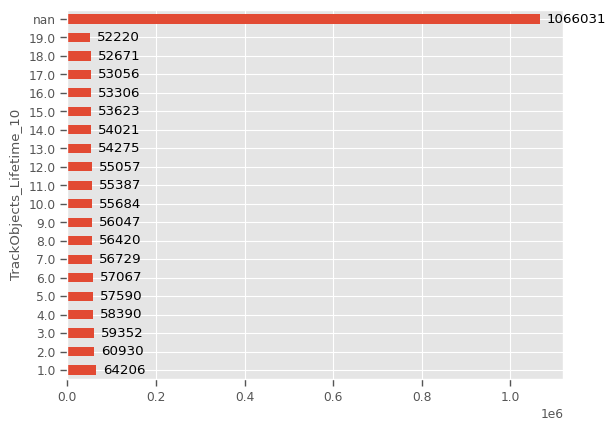

In [24]:
ax = df["TrackObjects_Lifetime_10"].value_counts(dropna=False).sort_index().plot(kind="barh")
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

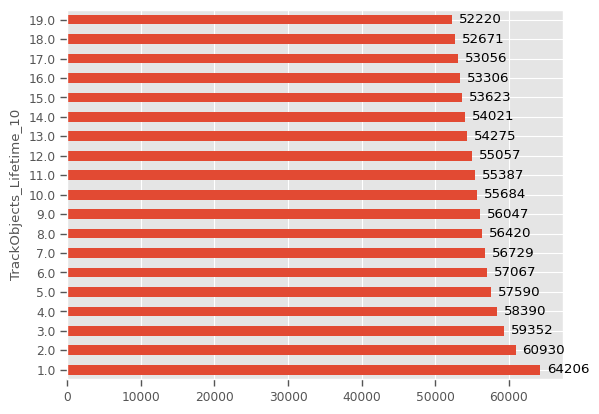

In [25]:
ax = df["TrackObjects_Lifetime_10"].value_counts(dropna=True).sort_index().plot(kind="barh")
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

### Final lifetime

In [ ]:
df.groupby("file")["TrackObjects_FinalAge_10"].value_counts(dropna=False)

file              TrackObjects_FinalAge_10
filtered_nucleus  NaN                          994085
                  19.0                          52220
                  1.0                            5871
                  2.0                            2290
                  3.0                            1544
                  4.0                            1164
                  12.0                           1024
                  5.0                             943
                  7.0                             728
                  6.0                             721
                  9.0                             646
                  8.0                             634
                  18.0                            612
                  10.0                            557
                  11.0                            550
                  16.0                            514
                  14.0                            503
                  13.0                 

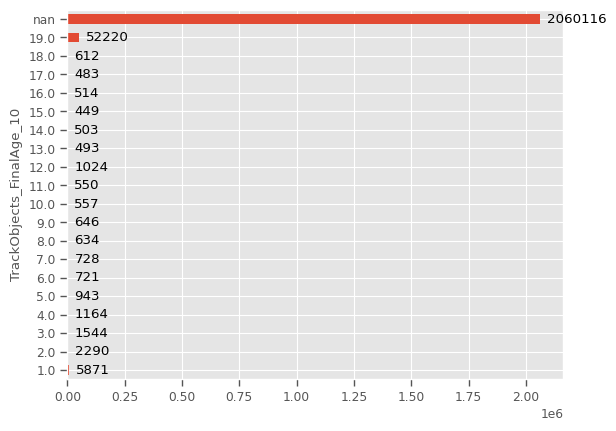

In [26]:
ax = df["TrackObjects_FinalAge_10"].value_counts(dropna=False).sort_index().plot(kind="barh")
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

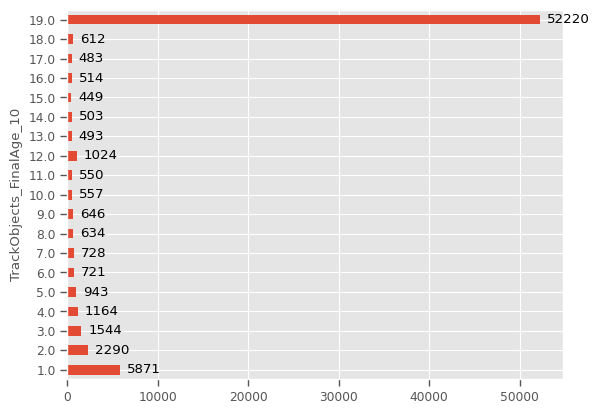

In [27]:
ax = df["TrackObjects_FinalAge_10"].value_counts(dropna=True).sort_index().plot(kind="barh")
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

# Select objects with full lifetime 

(ie final age 19)

## First assign a global object ID

### ObjectNumber analysis 

(not an actual object identifier as not coherent through time)

In [199]:
assert not df["Metadata_VideoID"].isna().any()
print(df["ObjectNumber"].isna().sum())  # these are potential image files, it's ok
df[df["ObjectNumber"].isna()]["file"]

0


Series([], Name: file, dtype: object)

In [ ]:
df["not_an_id"] = df["Metadata_VideoID"].astype(str) + "-" + df["ObjectNumber"].astype(str)
assert not df["not_an_id"].isna().any()
df["not_an_id"].value_counts(dropna=False)

local_object_id
A_14_fld_3-1      38
J_14_fld_4-74     38
J_14_fld_4-63     38
J_14_fld_4-64     38
J_14_fld_4-65     38
                  ..
K_13_fld_1-535     2
K_13_fld_1-536     2
K_13_fld_1-537     2
K_13_fld_1-538     2
O_14_fld_4-443     2
Name: count, Length: 57860, dtype: int64

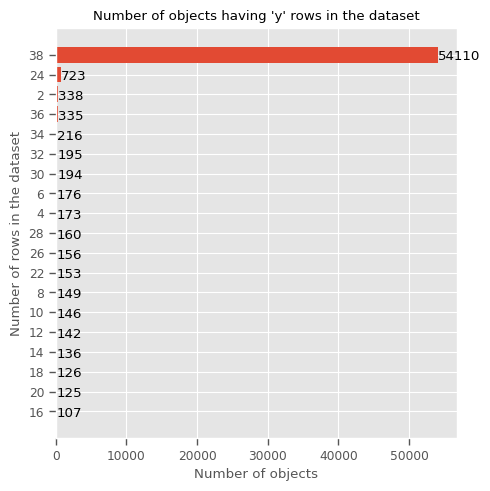

In [ ]:
plt.figure(figsize=(5, 5))
x, y = np.unique(df["not_an_id"].value_counts(dropna=False).values, return_counts=True)
sorted_indices = np.argsort(y)
y = y[sorted_indices]
x = x[sorted_indices]
plt.yticks(ticks=np.arange(len(x)), labels=x)
bars = plt.barh(np.arange(len(x)), y)
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2 - 0.1,
        bar.get_width(),
        va="center",
    )
plt.xlabel("Number of objects")
plt.ylabel("Number of rows in the dataset")
plt.title("Number of objects having 'y' rows in the dataset")
plt.tight_layout()
# plt.xscale("log")
plt.show()

### TrackObjects_Label_10 analysis

In [57]:
df.groupby("file")["TrackObjects_Label_10"].apply(lambda x: x.isna().sum())

file
filtered_nucleus          0
whole_cell          1066031
Name: TrackObjects_Label_10, dtype: int64

TrackObjects_Label_10 is only assigned to filtered_nucleus, and assigned to all of them

In [59]:
maks_trackobject_label_exists = df["TrackObjects_Label_10"].notna()
df.loc[maks_trackobject_label_exists, "global_object_id"] = (
    df["Metadata_VideoID"].astype(str) + "-" + df["TrackObjects_Label_10"].astype(str)
)
df["global_object_id"].value_counts(dropna=False)

global_object_id
NaN                 1066031
C_14_fld_2-495.0         89
E_14_fld_2-12.0          72
C_14_fld_3-145.0         70
C_13_fld_1-230.0         69
                     ...   
B_14_fld_1-600.0          1
B_14_fld_1-595.0          1
B_14_fld_1-589.0          1
B_14_fld_1-581.0          1
O_14_fld_4-496.0          1
Name: count, Length: 64207, dtype: int64

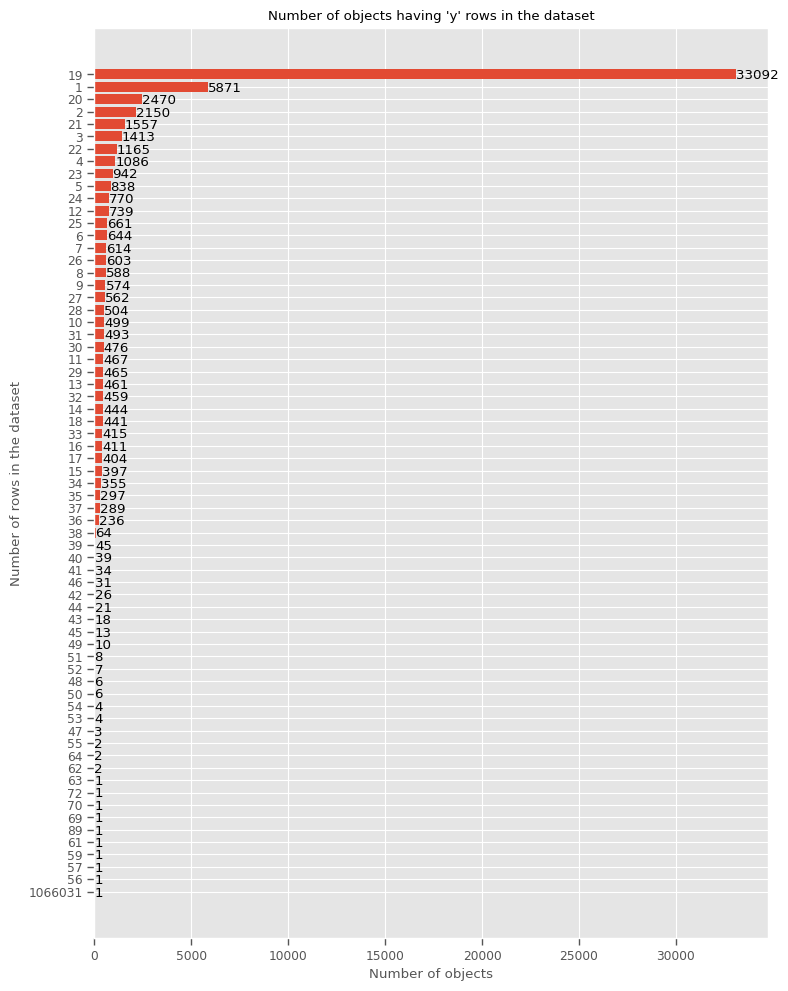

In [60]:
plt.figure(figsize=(8, 10))
x, y = np.unique(df["global_object_id"].value_counts(dropna=False).values, return_counts=True)
sorted_indices = np.argsort(y)
y = y[sorted_indices]
x = x[sorted_indices]
plt.yticks(ticks=np.arange(len(x)), labels=x)
bars = plt.barh(np.arange(len(x)), y)
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2 - 0.1,
        bar.get_width(),
        va="center",
    )
plt.title("Number of objects having 'y' rows in the dataset")
plt.xlabel("Number of objects")
plt.ylabel("Number of rows in the dataset")
plt.tight_layout()
# plt.xscale("log")
plt.show()

`TrackObjects_Label_10` is the correct object ID

Some checks:

In [64]:
df.groupby("global_object_id")["TrackObjects_FinalAge_10"].unique()

global_object_id
A_13_fld_1-1.0       [nan, 5.0]
A_13_fld_1-10.0      [nan, 6.0]
A_13_fld_1-100.0    [nan, 12.0]
A_13_fld_1-101.0    [nan, 12.0]
A_13_fld_1-102.0    [nan, 12.0]
                       ...     
O_14_fld_4-95.0     [nan, 19.0]
O_14_fld_4-96.0     [nan, 19.0]
O_14_fld_4-97.0     [nan, 19.0]
O_14_fld_4-98.0     [nan, 19.0]
O_14_fld_4-99.0           [1.0]
Name: TrackObjects_FinalAge_10, Length: 64206, dtype: object

In [65]:
df.groupby("global_object_id")["TrackObjects_ParentObjectNumber_10"].unique()

global_object_id
A_13_fld_1-1.0                                        [0.0, 1.0, 2.0]
A_13_fld_1-10.0                               [0.0, 10.0, 14.0, 13.0]
A_13_fld_1-100.0    [0.0, 100.0, 98.0, 97.0, 99.0, 104.0, 103.0, 9...
A_13_fld_1-101.0    [0.0, 101.0, 94.0, 99.0, 93.0, 100.0, 96.0, 10...
A_13_fld_1-102.0    [0.0, 102.0, 100.0, 101.0, 109.0, 103.0, 104.0...
                                          ...                        
O_14_fld_4-95.0     [0.0, 95.0, 97.0, 105.0, 106.0, 107.0, 98.0, 1...
O_14_fld_4-96.0     [0.0, 96.0, 92.0, 99.0, 101.0, 100.0, 106.0, 1...
O_14_fld_4-97.0     [0.0, 97.0, 100.0, 107.0, 111.0, 110.0, 112.0,...
O_14_fld_4-98.0     [0.0, 98.0, 102.0, 110.0, 108.0, 101.0, 106.0,...
O_14_fld_4-99.0                                                 [0.0]
Name: TrackObjects_ParentObjectNumber_10, Length: 64206, dtype: object

## Then filter on objects with full lifetime

Note that objects with full lifetime might still split / merge somehow, see CellProfiler TrackObject doc.

**Important: we still want to keep the whole_cell measurements; they do not have a *global_object_id* for now!**

### First some checks

In [160]:
mask_objects_with_full_lifetime = df["TrackObjects_FinalAge_10"] == 19
objects_with_full_lifetime_ids = df.loc[
    mask_objects_with_full_lifetime, "global_object_id"
].unique()
print(f"There are {len(objects_with_full_lifetime_ids)} object IDs with full lifetime (19).")
objects_with_full_lifetime_ids  # these are all objects IDs with full lifetime (19)

There are 45535 object IDs with full lifetime (19).


array(['A_14_fld_3-1.0', 'A_14_fld_3-3.0', 'A_14_fld_3-5.0', ...,
       'O_14_fld_4-416.0', 'O_14_fld_4-414.0', 'O_14_fld_4-419.0'],
      dtype=object)

Some of these object IDs have multiple lines per time, eg @ time 19:

In [150]:
nb_base_obj_per_global_obj_time_19 = (
    df.loc[mask_objects_with_full_lifetime & (df["Metadata_time"] == 19)]
    .groupby("global_object_id")["ObjectNumber"]
    .nunique()
)

global_obj_ids_with_multiple = nb_base_obj_per_global_obj_time_19[
    nb_base_obj_per_global_obj_time_19 > 1
].index

In [172]:
df.loc[
    df["global_object_id"].isin(global_obj_ids_with_multiple) & (df["Metadata_time"] == 19),
    ["global_object_id", "ObjectNumber"],
].groupby("global_object_id").nunique(dropna=False).sort_values(
    "ObjectNumber", ascending=False, na_position="first"
)

,ObjectNumber
global_object_id,
C_14_fld_3-145.0,8
C_14_fld_2-495.0,7
I_14_fld_1-256.0,7
E_13_fld_1-73.0,6
L_13_fld_2-302.0,5
...,...
F_13_fld_2-457.0,2
F_13_fld_2-436.0,2
F_13_fld_2-430.0,2


but still only a single line per object-id + object number:

In [170]:
display(
    df.loc[
        df["global_object_id"].isin(global_obj_ids_with_multiple) & (df["Metadata_time"] == 19),
        ["global_object_id", "ObjectNumber"],
    ]
    .groupby("global_object_id")
    .value_counts(dropna=False)
    .sort_values(ascending=False, na_position="first")
)

global_object_id  ObjectNumber
A_13_fld_2-106.0  99              1
K_13_fld_1-215.0  212             1
K_13_fld_1-166.0  164             1
K_13_fld_1-179.0  168             1
                  189             1
                                 ..
F_13_fld_1-282.0  297             1
                  302             1
F_13_fld_1-284.0  293             1
                  296             1
O_14_fld_4-96.0   112             1
Name: count, Length: 12897, dtype: int64

check on all times:

In [169]:
df.loc[
    df["global_object_id"].isin(global_obj_ids_with_multiple),
    ["global_object_id", "ObjectNumber", "Metadata_time"],
].groupby("global_object_id").value_counts(dropna=False).sort_values(
    ascending=False, na_position="first"
)

global_object_id  ObjectNumber  Metadata_time
A_13_fld_2-106.0  94            9                1
K_13_fld_1-291.0  295           19               1
K_13_fld_1-27.0   38            11               1
                  28            10               1
                                6                1
                                                ..
F_13_fld_1-36.0   43            7                1
                  48            14               1
                                17               1
                  49            9                1
O_14_fld_4-96.0   116           15               1
Name: count, Length: 180837, dtype: int64

### Now assign global object IDs to "whole_cell" objects

because for now:

In [174]:
df.loc[df["global_object_id"].isin(objects_with_full_lifetime_ids), "file"].unique()

array(['filtered_nucleus'], dtype=object)

To assign the global object ID to the whole_cell objects, we "join" the filtered_nucleus and whole_cell dataframes on the frame (ie a video at a certain time) and the `ObjectNumber`. 

Check: we should see exactly 2 lines for each key: a whole_cell and a filtered_nucleus object.

In [ ]:
tmp_check = df.groupby(["FileName_images", "ObjectNumber"])["file"].value_counts(dropna=False)
display(tmp_check)
assert not tmp_check.isna().any()
assert len(tmp_check) == len(df)
assert tmp_check.unique() == [1]  # always 1 line per key and file type

FileName_images         ObjectNumber  file            
A_13_fld_1_time_01.png  1             filtered_nucleus    1
                                      whole_cell          1
                        2             whole_cell          1
                                      filtered_nucleus    1
                        3             whole_cell          1
                                                         ..
O_14_fld_4_time_19.png  433           filtered_nucleus    1
                        434           whole_cell          1
                                      filtered_nucleus    1
                        435           filtered_nucleus    1
                                      whole_cell          1
Name: count, Length: 2132062, dtype: int64

Now assign the global object ID to the whole_cell objects:

In [221]:
# first get the local id -> global id mapping

series_of_global_ids_indexed_by_local_id = df[df["file"] == "filtered_nucleus"].set_index(
    ["FileName_images", "ObjectNumber"]
)["global_object_id"]
series_of_global_ids_indexed_by_local_id

FileName_images         ObjectNumber
A_14_fld_3_time_01.png  1                 A_14_fld_3-1.0
                        2                 A_14_fld_3-2.0
                        3                 A_14_fld_3-3.0
                        4                 A_14_fld_3-4.0
                        5                 A_14_fld_3-5.0
                                              ...       
O_14_fld_4_time_19.png  431             O_14_fld_4-483.0
                        432             O_14_fld_4-419.0
                        433             O_14_fld_4-495.0
                        434             O_14_fld_4-483.0
                        435             O_14_fld_4-496.0
Name: global_object_id, Length: 1066031, dtype: object

In [ ]:
# then fill the whole_cell global_object_id column
whole_cell_mask = df["file"] == "whole_cell"

lookup_idx = pd.MultiIndex.from_frame(df.loc[whole_cell_mask, ["FileName_images", "ObjectNumber"]])

df.loc[whole_cell_mask, "global_object_id"] = series_of_global_ids_indexed_by_local_id.loc[
    lookup_idx
].values

assert all(df.groupby(["FileName_images", "ObjectNumber"])["global_object_id"].nunique() == 1)

### Finally filter the data on objects having full lifetime

In [230]:
assert not df["global_object_id"].isna().any()

In [231]:
df_full_lifetimes = df[df["global_object_id"].isin(objects_with_full_lifetime_ids)]
df_full_lifetimes

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,...,TrackObjects_Lifetime_10,TrackObjects_Linearity_10,TrackObjects_ParentImageNumber_10,TrackObjects_ParentObjectNumber_10,TrackObjects_TrajectoryX_10,TrackObjects_TrajectoryY_10,file,Parent_filtered_nucleus,local_object_id,global_object_id
0,108,1,file:/projects/static2dynamic/datasets/biotine...,0,0,A_14_fld_3,A_14_fld_3,A14,14,3,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,A_14_fld_3-1,A_14_fld_3-1.0
2,108,3,file:/projects/static2dynamic/datasets/biotine...,0,0,A_14_fld_3,A_14_fld_3,A14,14,3,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,A_14_fld_3-3,A_14_fld_3-3.0
4,108,5,file:/projects/static2dynamic/datasets/biotine...,0,0,A_14_fld_3,A_14_fld_3,A14,14,3,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,A_14_fld_3-5,A_14_fld_3-5.0
5,108,6,file:/projects/static2dynamic/datasets/biotine...,0,0,A_14_fld_3,A_14_fld_3,A14,14,3,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,A_14_fld_3-6,A_14_fld_3-6.0
6,108,7,file:/projects/static2dynamic/datasets/biotine...,0,0,A_14_fld_3,A_14_fld_3,A14,14,3,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,A_14_fld_3-7,A_14_fld_3-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132053,2273,427,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_4,O_14_fld_4,O14,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,427.0,O_14_fld_4-427,O_14_fld_4-409.0
2132054,2273,428,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_4,O_14_fld_4,O14,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,428.0,O_14_fld_4-428,O_14_fld_4-411.0
2132055,2273,429,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_4,O_14_fld_4,O14,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,429.0,O_14_fld_4-429,O_14_fld_4-416.0
2132056,2273,430,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_4,O_14_fld_4,O14,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,430.0,O_14_fld_4-430,O_14_fld_4-414.0


In [232]:
df_full_lifetimes["TrackObjects_FinalAge_10"].value_counts(dropna=False)

TrackObjects_FinalAge_10
NaN     1851448
19.0      52220
Name: count, dtype: int64

check consistency of filtered dataframe:

In [233]:
df_full_lifetimes[["file", "TrackObjects_FinalAge_10"]].value_counts(dropna=False)

file              TrackObjects_FinalAge_10
whole_cell        NaN                         951834
filtered_nucleus  NaN                         899614
                  19.0                         52220
Name: count, dtype: int64

In [251]:
df_full_lifetimes["global_object_id"].nunique()

45535

# Plot a feature of a cell

## Select video

In [234]:
video_id = "M_13_fld_2"

In [235]:
df_this_vid = df_full_lifetimes.query(f"Metadata_VideoID == '{video_id}'")
df_this_vid

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,...,TrackObjects_Lifetime_10,TrackObjects_Linearity_10,TrackObjects_ParentImageNumber_10,TrackObjects_ParentObjectNumber_10,TrackObjects_TrajectoryX_10,TrackObjects_TrajectoryY_10,file,Parent_filtered_nucleus,local_object_id,global_object_id
1714196,1837,1,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,M_13_fld_2-1,M_13_fld_2-1.0
1714197,1837,2,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,M_13_fld_2-2,M_13_fld_2-2.0
1714198,1837,3,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,M_13_fld_2-3,M_13_fld_2-3.0
1714199,1837,4,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,M_13_fld_2-4,M_13_fld_2-4.0
1714200,1837,5,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,M_13_fld_2-5,M_13_fld_2-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734443,1855,531,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,531.0,M_13_fld_2-531,M_13_fld_2-496.0
1734445,1855,533,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,533.0,M_13_fld_2-533,M_13_fld_2-515.0
1734446,1855,534,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,534.0,M_13_fld_2-534,M_13_fld_2-515.0
1734447,1855,535,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,535.0,M_13_fld_2-535,M_13_fld_2-514.0


## Select object

In [236]:
object_number = "274.0"

note that querying on `TrackObjects_Label_10` selects the filtered_nucleus objects only, since whole_cells are not tracked.

In [237]:
df_this_vid_this_object = df_this_vid.query(f"TrackObjects_Label_10 == {object_number}")
df_this_vid_this_object

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,...,TrackObjects_Lifetime_10,TrackObjects_Linearity_10,TrackObjects_ParentImageNumber_10,TrackObjects_ParentObjectNumber_10,TrackObjects_TrajectoryX_10,TrackObjects_TrajectoryY_10,file,Parent_filtered_nucleus,local_object_id,global_object_id
1714469,1837,274,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,1.0,NaN,0.0,0.0,0.000000,0.000000,filtered_nucleus,NaN,M_13_fld_2-274,M_13_fld_2-274.0
1715005,1838,283,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,2.0,1.000000,1837.0,274.0,2.724579,15.021075,filtered_nucleus,NaN,M_13_fld_2-283,M_13_fld_2-274.0
1715540,1839,283,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,3.0,0.998226,1838.0,283.0,3.564843,11.549371,filtered_nucleus,NaN,M_13_fld_2-283,M_13_fld_2-274.0
1716076,1840,290,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,4.0,0.993826,1839.0,283.0,3.672753,7.308088,filtered_nucleus,NaN,M_13_fld_2-290,M_13_fld_2-274.0
1716611,1841,288,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,5.0,0.992811,1840.0,290.0,0.982378,8.338285,filtered_nucleus,NaN,M_13_fld_2-288,M_13_fld_2-274.0
1717139,1842,290,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,6.0,0.982797,1841.0,288.0,-1.167847,5.017548,filtered_nucleus,NaN,M_13_fld_2-290,M_13_fld_2-274.0
1717671,1843,291,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,7.0,0.982243,1842.0,290.0,-0.106940,3.830688,filtered_nucleus,NaN,M_13_fld_2-291,M_13_fld_2-274.0
1718204,1844,288,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,8.0,0.964833,1843.0,291.0,2.440774,1.247390,filtered_nucleus,NaN,M_13_fld_2-288,M_13_fld_2-274.0
1718736,1845,287,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,9.0,0.950812,1844.0,288.0,-1.591843,2.106096,filtered_nucleus,NaN,M_13_fld_2-287,M_13_fld_2-274.0
1719264,1846,286,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,10.0,0.915137,1845.0,287.0,-2.553148,0.806360,filtered_nucleus,NaN,M_13_fld_2-286,M_13_fld_2-274.0


See where is the object in the video

In [238]:
df_this_vid_this_object[
    ["global_object_id", "Metadata_time", "AreaShape_Center_X", "AreaShape_Center_Y"]
]

,global_object_id,Metadata_time,AreaShape_Center_X,AreaShape_Center_Y
1714469,M_13_fld_2-274.0,1,1268.429500,1062.132500
1715005,M_13_fld_2-274.0,2,1271.154079,1077.153575
1715540,M_13_fld_2-274.0,3,1274.718922,1088.702946
1716076,M_13_fld_2-274.0,4,1278.391675,1096.011033
1716611,M_13_fld_2-274.0,5,1279.374054,1104.349319
1717139,M_13_fld_2-274.0,6,1278.206206,1109.366867
1717671,M_13_fld_2-274.0,7,1278.099267,1113.197555
1718204,M_13_fld_2-274.0,8,1280.540040,1114.444945
1718736,M_13_fld_2-274.0,9,1278.948197,1116.551041
1719264,M_13_fld_2-274.0,10,1276.395049,1117.357401


## Select feature

In [239]:
list(df_this_vid_this_object.columns)

['ImageNumber',
 'ObjectNumber',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_VideoID',
 'Metadata_VideoID.1',
 'Metadata_Well',
 'Metadata_column',
 'Metadata_field',
 'Metadata_row',
 'Metadata_time',
 'FileName_images',
 'PathName_images',
 'AreaShape_Area',
 'AreaShape_BoundingBoxArea',
 'AreaShape_BoundingBoxMaximum_X',
 'AreaShape_BoundingBoxMaximum_Y',
 'AreaShape_BoundingBoxMinimum_X',
 'AreaShape_BoundingBoxMinimum_Y',
 'AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_CentralMoment_0_0',
 'AreaShape_CentralMoment_0_1',
 'AreaShape_CentralMoment_0_2',
 'AreaShape_CentralMoment_0_3',
 'AreaShape_CentralMoment_1_0',
 'AreaShape_CentralMoment_1_1',
 'AreaShape_CentralMoment_1_2',
 'AreaShape_CentralMoment_1_3',
 'AreaShape_CentralMoment_2_0',
 'AreaShape_CentralMoment_2_1',
 'AreaShape_CentralMoment_2_2',
 'AreaShape_CentralMoment_2_3',
 'AreaShape_Compactness',
 'AreaShape_ConvexArea',
 'AreaShape_Eccentricity',
 'AreaShape_EquivalentDiamete

In [240]:
feature = "AreaShape_Area"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


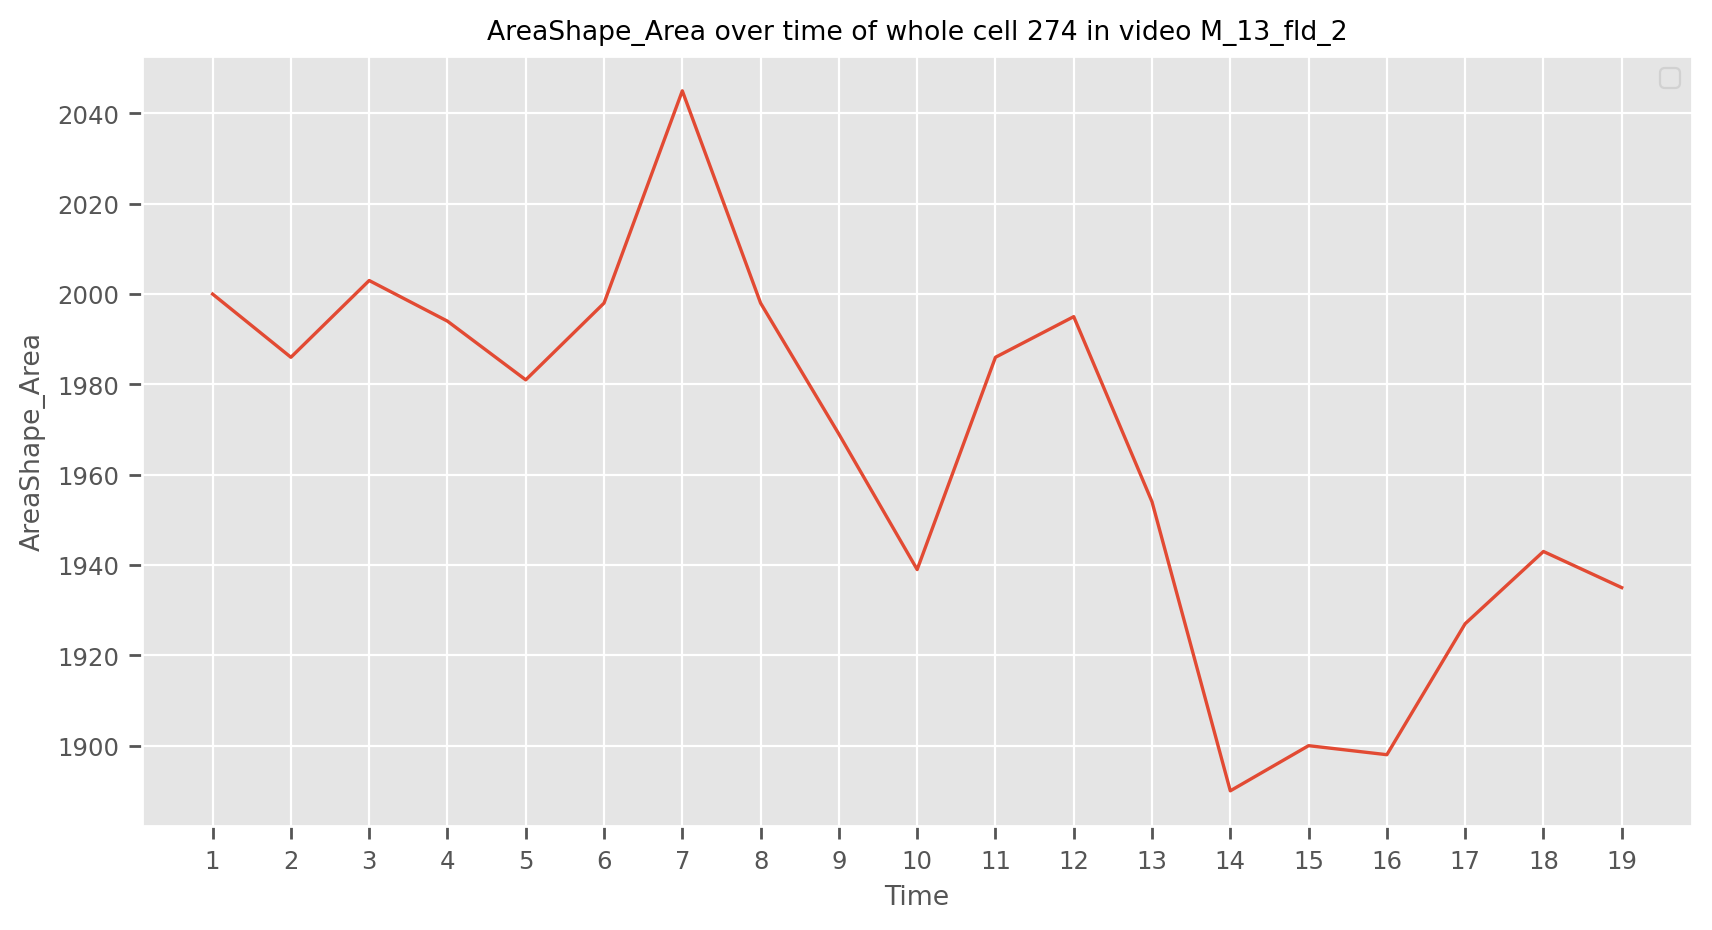

In [241]:
plt.figure(dpi=200, figsize=(10, 5))

plt.plot(df_this_vid_this_object[feature].reset_index(drop=True))
plt.xticks(
    ticks=range(len(df_this_vid_this_object)),
    labels=range(1, len(df_this_vid_this_object) + 1),
)
plt.title(f"{feature} over time of whole cell {int(float(object_number))} in video {video_id}")
plt.ylabel(f"{feature}")
plt.xlabel("Time")
plt.legend(loc="upper right")
plt.show()

# Save timeseries of all features for all tracked objects

In [ ]:
list(df_this_vid_this_object.columns)

['ImageNumber',
 'ObjectNumber',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_VideoID',
 'Metadata_VideoID.1',
 'Metadata_Well',
 'Metadata_column',
 'Metadata_field',
 'Metadata_row',
 'Metadata_time',
 'FileName_images',
 'PathName_images',
 'AreaShape_Area',
 'AreaShape_BoundingBoxArea',
 'AreaShape_BoundingBoxMaximum_X',
 'AreaShape_BoundingBoxMaximum_Y',
 'AreaShape_BoundingBoxMinimum_X',
 'AreaShape_BoundingBoxMinimum_Y',
 'AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_CentralMoment_0_0',
 'AreaShape_CentralMoment_0_1',
 'AreaShape_CentralMoment_0_2',
 'AreaShape_CentralMoment_0_3',
 'AreaShape_CentralMoment_1_0',
 'AreaShape_CentralMoment_1_1',
 'AreaShape_CentralMoment_1_2',
 'AreaShape_CentralMoment_1_3',
 'AreaShape_CentralMoment_2_0',
 'AreaShape_CentralMoment_2_1',
 'AreaShape_CentralMoment_2_2',
 'AreaShape_CentralMoment_2_3',
 'AreaShape_Compactness',
 'AreaShape_ConvexArea',
 'AreaShape_Eccentricity',
 'AreaShape_EquivalentDiamete

In [245]:
features_to_save = [
    feat for feat in df.columns if feat.startswith("AreaShape") or feat.startswith("Location")
]

# add meta data, including global_object_id and time
features_to_save += ["file", "Metadata_time", "global_object_id"]

print(f"Saving {len(features_to_save)} features or meta data")
features_to_save

Saving 114 features or meta data


['AreaShape_Area',
 'AreaShape_BoundingBoxArea',
 'AreaShape_BoundingBoxMaximum_X',
 'AreaShape_BoundingBoxMaximum_Y',
 'AreaShape_BoundingBoxMinimum_X',
 'AreaShape_BoundingBoxMinimum_Y',
 'AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_CentralMoment_0_0',
 'AreaShape_CentralMoment_0_1',
 'AreaShape_CentralMoment_0_2',
 'AreaShape_CentralMoment_0_3',
 'AreaShape_CentralMoment_1_0',
 'AreaShape_CentralMoment_1_1',
 'AreaShape_CentralMoment_1_2',
 'AreaShape_CentralMoment_1_3',
 'AreaShape_CentralMoment_2_0',
 'AreaShape_CentralMoment_2_1',
 'AreaShape_CentralMoment_2_2',
 'AreaShape_CentralMoment_2_3',
 'AreaShape_Compactness',
 'AreaShape_ConvexArea',
 'AreaShape_Eccentricity',
 'AreaShape_EquivalentDiameter',
 'AreaShape_EulerNumber',
 'AreaShape_Extent',
 'AreaShape_FormFactor',
 'AreaShape_HuMoment_0',
 'AreaShape_HuMoment_1',
 'AreaShape_HuMoment_2',
 'AreaShape_HuMoment_3',
 'AreaShape_HuMoment_4',
 'AreaShape_HuMoment_5',
 'AreaShape_HuMoment_6',
 'AreaShape_InertiaTens

In [248]:
features_through_time = df_full_lifetimes[features_to_save].copy(deep=False)
features_through_time

,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,AreaShape_CentralMoment_0_0,AreaShape_CentralMoment_0_1,...,AreaShape_Zernike_9_3,AreaShape_Zernike_9_5,AreaShape_Zernike_9_7,AreaShape_Zernike_9_9,Location_Center_X,Location_Center_Y,Location_Center_Z,file,Metadata_time,global_object_id
0,1487,2028,1769,43,1717,4,1741.929388,23.479489,1487.0,3.705480e-12,...,0.002436,0.004550,0.005971,0.003582,1741.929388,23.479489,0,filtered_nucleus,1,A_14_fld_3-1.0
2,1321,1680,1087,70,1045,30,1065.218774,50.993944,1321.0,9.592327e-13,...,0.004662,0.002412,0.004315,0.004143,1065.218774,50.993944,0,filtered_nucleus,1,A_14_fld_3-3.0
4,2201,3050,1958,97,1908,36,1932.359382,66.217628,2201.0,4.547474e-13,...,0.004070,0.000851,0.003022,0.000763,1932.359382,66.217628,0,filtered_nucleus,1,A_14_fld_3-5.0
5,2499,3102,239,106,192,40,214.739496,70.303321,2499.0,-5.435652e-13,...,0.004624,0.004621,0.011114,0.003636,214.739496,70.303321,0,filtered_nucleus,1,A_14_fld_3-6.0
6,1363,1872,389,85,353,33,369.783566,58.837124,1363.0,5.293543e-13,...,0.003826,0.005008,0.006446,0.003454,369.783566,58.837124,0,filtered_nucleus,1,A_14_fld_3-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132053,2817,5922,170,2011,107,1917,143.840256,1955.967341,2817.0,-1.041656e-11,...,0.001370,0.007824,0.005543,0.001893,143.840256,1955.967341,0,whole_cell,19,O_14_fld_4-409.0
2132054,3866,9000,584,2017,484,1927,543.527677,1967.716244,3866.0,2.835066e-12,...,0.010373,0.010213,0.007253,0.003667,543.527677,1967.716244,0,whole_cell,19,O_14_fld_4-411.0
2132055,2064,2773,1452,1980,1393,1933,1422.128391,1955.972868,2064.0,-1.243805e-11,...,0.012363,0.002858,0.009886,0.002310,1422.128391,1955.972868,0,whole_cell,19,O_14_fld_4-416.0
2132056,2506,4959,449,2028,392,1941,420.860734,1982.488428,2506.0,-1.790568e-12,...,0.003606,0.003507,0.005586,0.003656,420.860734,1982.488428,0,whole_cell,19,O_14_fld_4-414.0


In [249]:
df_full_lifetimes["global_object_id"].nunique(dropna=False)

45535

## Save

In [253]:
data_path

PosixPath('analyses/biotine_nuclei_tracked')

In [256]:
save_path = data_path / "features_through_time_of_full_lifetime_cells.csv"
if save_path.exists():
    raise RuntimeError(f"{save_path} already exists")

features_through_time.to_parquet(save_path, index=False)